In [1]:
from typing import Any

import lightning.pytorch as pl
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
import mlflow
from torch.utils.data import DataLoader, Dataset

from src.ml.data.splitting import create_data_splits
from src.ml.modeling import (
    model_factory,
    optimizer_factory,
)
from src.ml.utils.set_seed import set_seed

from datetime import datetime
from loguru import logger
from pathlib import Path
from shutil import copy, copytree, rmtree

import yaml

from src.ml.train_neural_network import train_neural_network
from src.ml.data import data_sets_factory
from src.ml.preprocessing import preprocessing_factory
from src.ml.utils.set_seed import set_seed

In [2]:
CONFIG_FILE = Path("src/ml/config.yaml")

In [3]:
torch.set_default_device(torch.device("cpu"))

In [4]:
# load config file

logger.info("Loading config file.")

with open(CONFIG_FILE, "r") as f:
    config = yaml.safe_load(f)

2025-01-10 13:35:11.928 | INFO     | __main__:<module>:3 - Loading config file.


In [5]:
# load data

logger.info("Loading data.")

_, data_sets = next(iter(data_sets_factory(**config["data_set"])))

# preprocess data

logger.info("Start preprocessing.")

for preprocessing_step in config["preprocessing"]:
    logger.info("Perform {} preprocessing.", preprocessing_step["name"])

    transform = preprocessing_factory(**preprocessing_step)
    data_sets = transform(data_sets)

dataset = data_sets

2025-01-10 13:35:11.973 | INFO     | __main__:<module>:3 - Loading data.
2025-01-10 13:35:19.954 | INFO     | __main__:<module>:9 - Start preprocessing.
2025-01-10 13:35:19.955 | INFO     | __main__:<module>:12 - Perform add_taxa_names preprocessing.
2025-01-10 13:35:20.870 | INFO     | __main__:<module>:12 - Perform add_relative_clade_information preprocessing.
2025-01-10 13:35:22.295 | INFO     | __main__:<module>:12 - Perform remove_tree preprocessing.


In [6]:
train_dataset, val_dataset, test_dataset = create_data_splits(
    dataset, **config["training"]["splitting_config"]
)

In [7]:
train_loader = DataLoader(train_dataset, **config["training"]["dataloader_config"])
test_loader = DataLoader(test_dataset,batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=128)

optimizer = optimizer_factory(**config["training"]["optimizer_config"])
model = model_factory(
    optimizer=optimizer,
    input_example=train_dataset[0],
    **config["training"]["model_config"],
)

In [8]:
from src.ml.modeling.weight_sharing_tree_flow import WeightSharingTreeFlow

model = WeightSharingTreeFlow.load_from_checkpoint("ml_data/models/debug_batch_norm_2025_01_10_13_17_21/yule-10_5/epoch=29-val_loss=-27.28.ckpt")
model = model.eval()

<Axes: xlabel='None', ylabel='None'>

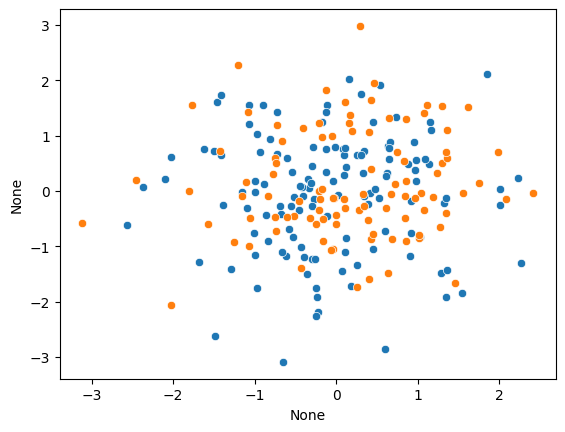

In [9]:
import seaborn as sns
sample = next(iter(val_loader))
latent_space = model.forward(sample)["z"].detach().numpy()
sns.scatterplot(x=latent_space[:, -1], y=latent_space[:, 1])

prior_latent_space = model.sample_from_base((100,2))
sns.scatterplot(x=prior_latent_space[:, 0], y=prior_latent_space[:, 1])

In [10]:
latent = model.forward(sample)
output = model.inverse(latent)

In [11]:
sample["branch_lengths"][0], output["branch_lengths"][0]

(tensor([9.0318e-01, 1.2429e-01, 9.0284e-01, 4.0507e-01, 1.0778e-02, 1.1822e-01,
         1.2223e-01, 3.3802e-01, 1.0000e-06]),
 tensor([9.0318e-01, 1.2429e-01, 9.0284e-01, 4.0507e-01, 1.0778e-02, 1.1822e-01,
         1.2223e-01, 3.3802e-01, 1.0000e-06], grad_fn=<SelectBackward0>))

<Axes: ylabel='Count'>

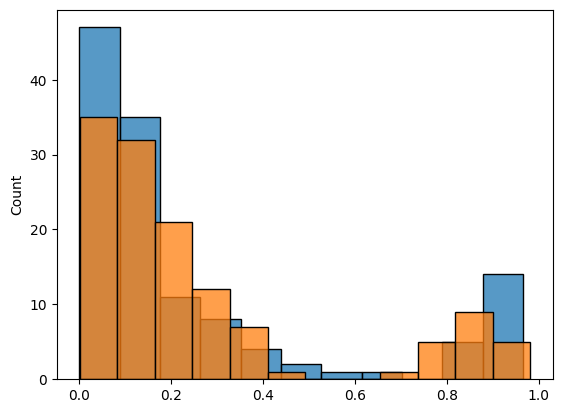

In [12]:
prior = model.sample_from_base((10000, 63))
latent = model.forward(sample)
rs = model.inverse(latent)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:, 2])

latent["z"] = prior.clone()
rs = model.sample(sample)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:, 2])

<Axes: ylabel='Density'>

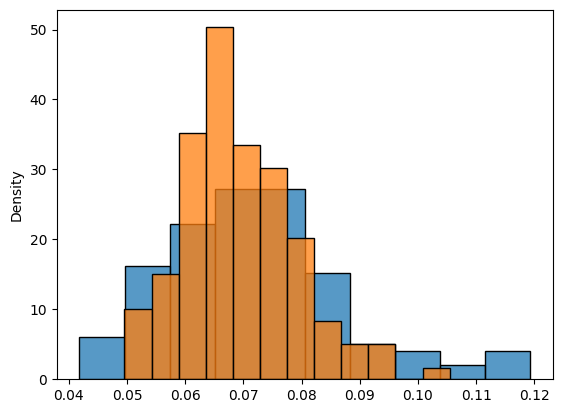

In [31]:
sns.histplot(model.sample(sample)["tree_height"], stat="density")
sns.histplot(sample["tree_height"], stat="density")

In [14]:
from loguru import logger
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader

import yaml

from src.ml.preprocessing.add_relative_clade_information import AddRelativeCladeInformation
from src.ml.data.tree_dataset import TreeDataset
from src.ml.modeling import model_factory, optimizer_factory
from src.ml.modeling.conditional_tree_flow import ConditionalTreeFlow
from src.ml.modeling.weight_sharing_tree_flow import WeightSharingTreeFlow
from src.ml.preprocessing import preprocessing_factory

from src.datasets.load_trees import write_trees_to_file, load_trees_from_file

OUTPUT_DIR = Path("data/map_data")

MODEL_NAME = "nf-weight-sharing"
MODELS_PATH = Path("ml_data/models/debug_2025_01_09_13_31_47")
CONFIG_PATH = Path("ml_data/output/config.yaml")


def _load_config():
    with open(CONFIG_PATH, "r") as f:
        return yaml.safe_load(f)


def _load_data(trees_file: Path):
    logger.info("Loading data.")
    data_sets = [TreeDataset(trees_file)]
    return data_sets


def _preprocess_data(config, data_sets):
    logger.info("Start preprocessing.")

    for preprocessing_step in config["preprocessing"]:
        logger.info("Perform {} preprocessing.", preprocessing_step["name"])

        transform = preprocessing_factory(**preprocessing_step)
        data_sets = [transform(data_set) for data_set in data_sets]

    data_loader = DataLoader(data_sets[0], shuffle=False)

    return data_loader, data_sets[0][0]

def _load_model(config, input_example, data_set_name):
    optimizer = optimizer_factory(**config["training"]["optimizer_config"])
    model = model_factory(
        optimizer=optimizer,
        input_example=input_example,
        **config["training"]["model_config"],
    )

    model = WeightSharingTreeFlow.load_from_checkpoint(
        next((MODELS_PATH / data_set_name).glob("*.ckpt"))
    )
    model = model.eval()

    return model

In [15]:
map_tree_file = Path("data/map_data/yule-10_140_49247_mrca.trees")
dataset, run, num_samples, _ = map_tree_file.stem.split("_")

In [16]:
data_sets = _load_data(map_tree_file)
data_loader, input_example = _preprocess_data(config, data_sets)

2025-01-10 13:35:22.821 | INFO     | __main__:_load_data:31 - Loading data.
2025-01-10 13:35:22.823 | INFO     | __main__:_preprocess_data:37 - Start preprocessing.
2025-01-10 13:35:22.823 | INFO     | __main__:_preprocess_data:40 - Perform add_taxa_names preprocessing.
2025-01-10 13:35:22.823 | INFO     | __main__:_preprocess_data:40 - Perform add_relative_clade_information preprocessing.
2025-01-10 13:35:22.824 | INFO     | __main__:_preprocess_data:40 - Perform remove_tree preprocessing.


In [17]:
model = _load_model(config, input_example, f"{dataset}_{run}")

RuntimeError: Error(s) in loading state_dict for WeightSharingTreeFlow:
	Missing key(s) in state_dict: "log_alpha", "log_beta", "flows.1.translate.layers.1.weight", "flows.1.translate.layers.1.bias", "flows.1.scale.layers.1.weight", "flows.1.scale.layers.1.bias", "flows.2.translate.layers.1.weight", "flows.2.translate.layers.1.bias", "flows.2.scale.layers.1.weight", "flows.2.scale.layers.1.bias", "flows.3.translate.layers.1.weight", "flows.3.translate.layers.1.bias", "flows.3.scale.layers.1.weight", "flows.3.scale.layers.1.bias", "flows.4.translate.layers.1.weight", "flows.4.translate.layers.1.bias", "flows.4.scale.layers.1.weight", "flows.4.scale.layers.1.bias", "flows.5.translate.layers.1.weight", "flows.5.translate.layers.1.bias", "flows.5.scale.layers.1.weight", "flows.5.scale.layers.1.bias", "flows.6.translate.layers.1.weight", "flows.6.translate.layers.1.bias", "flows.6.scale.layers.1.weight", "flows.6.scale.layers.1.bias", "flows.7.translate.layers.1.weight", "flows.7.translate.layers.1.bias", "flows.7.scale.layers.1.weight", "flows.7.scale.layers.1.bias", "flows.8.translate.layers.1.weight", "flows.8.translate.layers.1.bias", "flows.8.scale.layers.1.weight", "flows.8.scale.layers.1.bias", "height_model.mean.weight", "height_model.mean.bias", "height_model.log_scale.weight", "height_model.log_scale.bias". 
	Unexpected key(s) in state_dict: "base_log_alpha", "base_log_beta", "flows.1.translate.layers.1.0.weight", "flows.1.translate.layers.1.0.bias", "flows.1.scale.layers.1.0.weight", "flows.1.scale.layers.1.0.bias", "flows.2.translate.layers.1.0.weight", "flows.2.translate.layers.1.0.bias", "flows.2.scale.layers.1.0.weight", "flows.2.scale.layers.1.0.bias", "flows.3.translate.layers.1.0.weight", "flows.3.translate.layers.1.0.bias", "flows.3.scale.layers.1.0.weight", "flows.3.scale.layers.1.0.bias", "flows.4.translate.layers.1.0.weight", "flows.4.translate.layers.1.0.bias", "flows.4.scale.layers.1.0.weight", "flows.4.scale.layers.1.0.bias", "flows.5.translate.layers.1.0.weight", "flows.5.translate.layers.1.0.bias", "flows.5.scale.layers.1.0.weight", "flows.5.scale.layers.1.0.bias", "flows.6.translate.layers.1.0.weight", "flows.6.translate.layers.1.0.bias", "flows.6.scale.layers.1.0.weight", "flows.6.scale.layers.1.0.bias", "flows.7.translate.layers.1.0.weight", "flows.7.translate.layers.1.0.bias", "flows.7.scale.layers.1.0.weight", "flows.7.scale.layers.1.0.bias", "flows.8.translate.layers.1.0.weight", "flows.8.translate.layers.1.0.bias", "flows.8.scale.layers.1.0.weight", "flows.8.scale.layers.1.0.bias", "height_model.mean", "height_model.scale". 

In [ ]:
first_and_only_batch = next(iter(data_loader))
samples = [
    model.sample(first_and_only_batch)["branch_lengths"] for _ in range(500)
]
samples = torch.cat(samples, dim=0)  # type: ignore
mean_sample = torch.mean(samples, dim=0)

# mean_sample = first_and_only_batch["branch_lengths"][0]

tree = load_trees_from_file(map_tree_file)[0]

AddRelativeCladeInformation.set_branch_lengths(
    tree,
    mean_sample.detach().numpy().tolist(),
    [int(x.detach()) for x in first_and_only_batch["clades"]],
    model.height_model.mode()
)

In [ ]:
model.height_model.mode()

0.03565124049782753

In [ ]:
model.height_model.sample((100,)).mean()

tensor(0.2397)

In [ ]:
first_and_only_batch["tree_height"]

tensor([0.0577], dtype=torch.float64)

In [ ]:
write_trees_to_file(
    [tree], "test.trees"
)

In [ ]:
list(zip([bin(int(x)) for x in first_and_only_batch["clades"]] , list(first_and_only_batch["branch_lengths"][0]) ))

[('0b110', tensor(1.)),
 ('0b1110', tensor(0.1195)),
 ('0b11110', tensor(0.4552)),
 ('0b11111', tensor(0.0728)),
 ('0b1100000', tensor(1.)),
 ('0b11100000', tensor(0.3626)),
 ('0b11111111', tensor(0.2785)),
 ('0b1100000000', tensor(1.)),
 ('0b1111111111', tensor(0.5770))]

In [ ]:
[int(x[0]) + 1 for x in first_and_only_batch["taxa_names"]]


[1, 6, 8, 7, 9, 4, 5, 10, 2, 3]

In [ ]:
0.3626 * (1 + 0.56)

0.5656559999999999

In [ ]:
from src.ml.modeling.layers.inverse_sigmoid_flow_layer import InverseSigmoidFlowLayer
from src.ml.modeling.layers.sigmoid_flow_layer import SigmoidFlowLayer


a = InverseSigmoidFlowLayer()

b = a.forward(torch.tensor([0.9, 0.1])) 
a.inverse(b["z"]), b

({'z': tensor([0.9000, 0.1000]), 'log_dj': tensor([-2.4079, -2.4079])},
 {'z': tensor([ 2.1972, -2.1972]), 'log_dj': tensor([2.4079, 2.4079])})

In [ ]:
b["z"]

tensor([0.5250, 0.1192])

In [ ]:
d = torch.sigmoid(torch.tensor([0.1, -2.0]))

In [ ]:
torch.log(d / (1 - d))

tensor([ 0.1000, -2.0000])

In [ ]:
a.inverse(d)

{'z': tensor([ 0.1000, -2.0000]), 'log_dj': tensor([1.3888, 2.2539])}